In [ ]:
%env CUDA_VISIBLE_DEVICES=0
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

from audio import DMD, STDMD, autils

No JAX installed. All computations will be ran with the standard CPU-backed `numpy` package.


In [3]:
FRAME_LENGTH = 1024
HOP_LENGTH = 512

y, sr = librosa.load('./data/lj_0.wav')
frames = librosa.util.frame(
    y, axis=0, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH
).astype(np.float32)
print(frames.shape)

print('max={}, min={}'.format(y.min(), y.max()))
display(Audio(y, rate=sr))

(360, 1024)
max=-0.340301513671875, min=0.411651611328125


#### Test on single frame

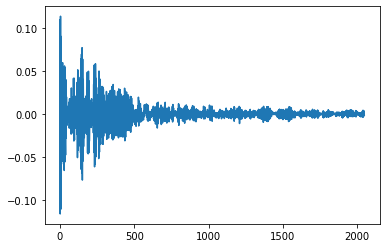

In [4]:
IDX = 20

frame = frames[IDX]
plt.plot(frame);
display(Audio(frame, rate=sr))

In [5]:
N_FREQS_TO_CAPTURE = 150
FL, HL = 2*N_FREQS_TO_CAPTURE, 1
N_CHANNELS = 120

subframes = librosa.util.frame(
    frame, axis=0, frame_length=FL, hop_length=HL
).astype(np.float32)
subframes.shape

(1749, 300)

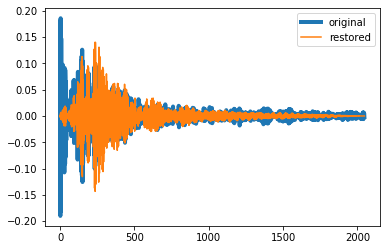

In [6]:
dmd = DMD(svd_rank=N_CHANNELS, opt='projected', lag=1)
subframes_hat = np.array(dmd.fit_reconstruct(subframes.T))
frame_hat = autils.frames_to_wave(subframes_hat.real.T, hop_length=HL)
plt.plot(frame / np.linalg.norm(frame), label='original', linewidth=4)
plt.plot(frame_hat / np.linalg.norm(frame_hat), label='restored')
plt.legend()
display(Audio(frame_hat, rate=sr))

In [8]:
dmd.modes.shape

(300, 120)

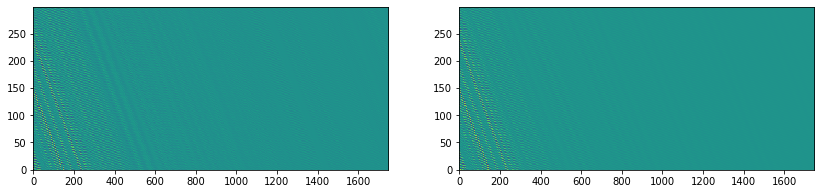

In [9]:
plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.imshow(subframes.real.T, aspect='auto', origin='bottom');
plt.subplot(1,2,2)
plt.imshow(subframes_hat.real, aspect='auto', origin='bottom');

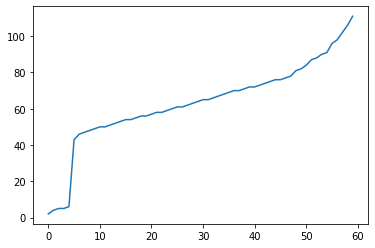

In [10]:
delta_t = HL / sr

freqs = np.log(dmd.eigvals).imag / (2 * np.pi * delta_t)
positive_mask = freqs > 0
freqs = freqs[positive_mask]
sorted_idx = np.argsort(freqs)
freqs = freqs[sorted_idx]
modes = dmd.modes[:, positive_mask][:, sorted_idx]
b = dmd.b[positive_mask][sorted_idx]
plt.plot(np.round(freqs / 11025 * N_CHANNELS));

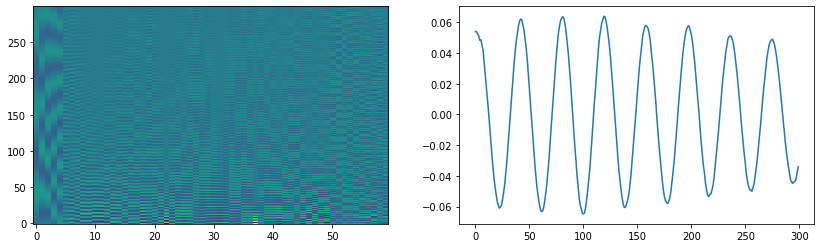

In [11]:
MODE_IDX = 4

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.imshow(modes.real, aspect='auto', origin='bottom')
plt.subplot(1,2,2)
plt.plot(modes.real[:, MODE_IDX]);

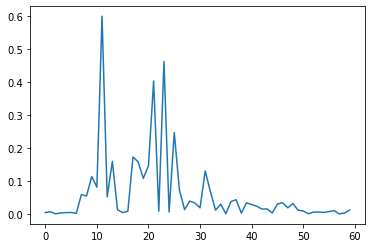

In [12]:
plt.plot(np.abs(b.real));

#### Test on whole signal

In [4]:
class STFT(object):
    def __init__(self, frame_length=1024, hop_length=256):
        self.frame_length = frame_length
        self.hop_length = hop_length
    
    def transform(self, x):
        frames = librosa.util.frame(
            x, frame_length=self.frame_length,
            hop_length=self.hop_length
        ).astype(np.float32).T
        
        return np.array([np.log10(np.abs(np.fft.rfft(frame.real).real) + 1e-6)
                         for frame in frames])

In [5]:
stdmd = STDMD(
    frame_length=FRAME_LENGTH,
    hop_length=HOP_LENGTH,
    n_channels=40,
    opt='projected',
    sampling_rate=22050,
    lag=1,
    n_jobs=10,
    verbose=True
)

In [6]:
dmdgram = stdmd.fit_transform(y)

100%|██████████| 360/360 [00:09<00:00, 39.27it/s]


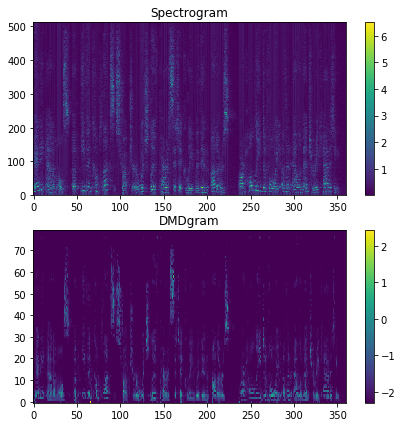

In [7]:
stft = STFT(frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)

plt.figure(figsize=(7, 7))
plt.subplot(2,1,1)
plt.title('Spectrogram')
plt.imshow(np.exp(stft.transform(y).T), aspect='auto', origin='bottom')
plt.colorbar()
plt.subplot(2,1,2)
plt.title('DMDgram')
plt.imshow(np.log(dmdgram.real.T + 1e-1), aspect='auto', origin='bottom')
plt.colorbar();